# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

### Loading Libraries and Exploring Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.weightstats as weightstats

df = pd.read_csv('data/human_body_temperature.csv')

df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [2]:
df.describe()

,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


### **1. Is the distribution of body temperatures normal?**

**Histogram**

Text(0,0.5,'Frequency')

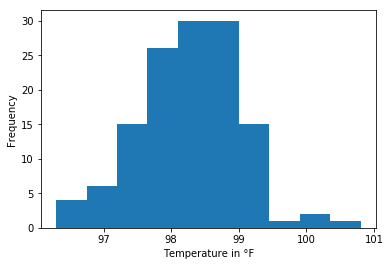

In [3]:
#First, we should take a look at this graphically.
df['temperature'].plot(kind = 'hist')
plt.xlabel('Temperature in °F')
plt.ylabel('Frequency')


**68-95-99.7 Rule**

The distribution looks roughly normal in the histogram, but let's check using the [68-95–99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) as well.

In [4]:
#Calculating the mean, standard deviation, and count of temperature values
mean = np.mean(df['temperature'])
std = np.std(df['temperature'])
count = np.sum(~np.isnan(df['temperature']))

#Finding % of values within 1, 2, and 3, standard deviations ofthe mean
perc_within_1_std = np.sum((df['temperature']>=(mean - std)) & (df['temperature']<=(mean + std)))/count
perc_within_2_std = np.sum((df['temperature']>=(mean - 2*std)) & (df['temperature']<=(mean + 2*std)))/count
perc_within_3_std = np.sum((df['temperature']>=(mean - 3*std)) & (df['temperature']<=(mean + 3*std)))/count
print('The percent of values with 1, 2, and 3, st. devs of the mean are',np.round(perc_within_1_std*100,1),'%,',np.round(perc_within_2_std*100,1),'%, and',np.round(perc_within_3_std*100,1),'% respectively.')

The percent of values with 1, 2, and 3, st. devs of the mean are 69.2 %, 94.6 %, and 99.2 % respectively.


That sounds pretty normal, however, I still would like to try using the scipy normality test.

**Normality Test**

The null hypothesis is that the data follow a normal distribution.

In [5]:
stats.normaltest(df['temperature'])

NormaltestResult(statistic=2.703801433319203, pvalue=0.2587479863488254)

With an α of .05,  the p-value is greater than α, and we fail to reject the null hypothesis that the data are
normally distributed. (However, we still can't conclude that they are normally distributed.)

### 2. Is the sample size large? Are the observations independent?


Generally, if you have more than 100 observations, and if your data is normally distributed, then your sample size is "large enough" for the central limit theorem to apply. Since there are 130 observations and the data appear to be normally distributed, we will consider the sample size large enough. The data are from a random sample and therefore the observations are independent. The conditions for the central limit theorem are met, so we will use statistical tests that rely on this assumption.

### 3. Is the true population mean really 98.6 °F ?

**Bootstrap Hypothesis Test**

Null Hypothesis: The true mean body temperature of the dataset is 98.6 °F. (The difference between the mean of the data and 98.6°F is zero.) 

In [6]:
#Calculating the test statistic
def diff_from_wunderlich(data, wunderlich = 98.6):
    return np.mean(data) - wunderlich

#Observed difference between JAMA's data's mean and Wunderlich's value of 98.6°F
diff_obs = diff_from_wunderlich(df['temperature'])
print("The mean from JAMA's data was", round(mean,2),"°F. while Wunderlich's value was 98.6°F.",'The question becomes, how likely is is that we would have observed a difference of',round(diff_obs,2),"°F if the true mean of JAMA's data was equal to Wunderlich's value?") 


The mean from JAMA's data was 98.25 °F. while Wunderlich's value was 98.6°F. The question becomes, how likely is is that we would have observed a difference of -0.35 °F if the true mean of JAMA's data was equal to Wunderlich's value?


Now, how reasonable are the observed data assuming the null hypothesis is true?

In [50]:
#Function for taking a bootstrap sample (sample with replacement) and returning a bootstrap replicate (statistic)
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample) 

#Function for generating and storing many bootstrap replicates in an array
def draw_bs_reps(data, func, size):
    """Draw and store many bootstrap replicates from 1D data."""
    bs_replicates = np.empty(size)
    for i in range (size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

#Shift dataset values such that JAMA's dataset's mean is 98.6 °F. This simulates the null hypothesis.
temperature_shifted = df['temperature'].values - mean + 98.6

#Draw bootstrapped replicates from shifted temperature data
bs_replicates = draw_bs_reps(temperature_shifted, diff_from_wunderlich, 10000)

#Compute the p-value, the portion of bootstrap replicates that are less than the observed test statistic.
#(We use less than, because the mean from JAMA's experiment was less than Wunderlich's value.)
p_value = np.sum(bs_replicates <= diff_obs)/10000

print("With a p_value of ",p_value,"we reject the null hypothesis, as it is very unlikely that we would see a value this extreme if the null hypothesis were true.")


With a p_value of  0.0 we reject the null hypothesis, as it is very unlikely that we would see a value this extreme if the null hypothesis were true.


**Frequentist Statistical Testing**

As we did above, we will use a [one-sample test](http://blog.minitab.com/blog/adventures-in-statistics-2/understanding-t-tests-1-sample-2-sample-and-paired-t-tests), because we are comparing one sample's mean to a null hypothesis value. 

In [51]:
#Although we don't know the population mean, the sample size is large enough that we can use a z-test
ste = std/np.sqrt(count)
z_score =(mean-98.6)/ste
p_value = stats.norm.sf(abs(z_score))*2 #Two-sided p_value

#Or, using weightstats:
#print(weightstats.ztest(df['temperature'], value=98.6, alternative='two-sided'))

print('The p_value is',p_value,'. Therefore, we reject the null hypothesis that the true sample mean is 98.6 °F. The sample mean is significantly statistically different from 98.6°F')

The p_value is 4.3523151658821886e-08 . Therefore, we reject the null hypothesis that the true sample mean is 98.6 °F. The sample mean is significantly statistically different from 98.6°F


In [11]:
#Even though it isn't the appropriate test in this case, let's see what a t test produces.
stats.ttest_1samp(df.temperature,98.6)

Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)

The results seem pretty similar, which makes sense because the sample size is over 100. The t test results would suggest to reject the null hypothesis as well. The p-value is higher, however, which means we would be less certain about rejecting the null hypothesis using a t test. 

 ### 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

In [53]:
#Draw a sample of size ten
small_sample = np.random.choice(df['temperature'], 10)
print("Small sample:",small_sample)

#One-sample, two-sided z test on small sample
print("Z Test Results:",weightstats.ztest(small_sample, value=98.6, alternative='two-sided'))

#One-sample, two-sided t test on small sample. (This is the appropriate one to use in this case because sample size is "small.")
print(stats.ttest_1samp(small_sample,98.6))

Small sample: [97.  98.2 98.2 98.5 99.  97.4 98.  98.6 97.4 99.3]
Z Test Results: (-1.8965830459556536, 0.05788298995211945)
Ttest_1sampResult(statistic=-1.8965830459556536, pvalue=0.0903804631309613)


After running the t and z tests a few times on the small sample, it looks like while the results tend to be similar, the p-value for the the t test tends to be higher, meaning that in each case, the t test suggests less certainty in rejecting/accepting the null hypothesis. (Rejecting in this case.) This is because the t test accounts for degrees of freedom and the fact that, the fewer observations you have the less certain you can be about your conclusions. 

### 5. At what temperature should we consider someone's temperature to be "abnormal"?

**Bootstrap Approach**

In [33]:
#Draw bootstrapped replicates from shifted temperature data
bs_replicates_mean_temp = draw_bs_reps(df['temperature'], np.mean, 10000)

#Computing a 95% confidence interval for bootstrap replicates
conf_int = np.percentile(bs_replicates_mean_temp, [2.5, 97.5])
print("The 95% confidence interval is",conf_int," for JAMA's dataset. For this group, we would consider a temperature outside of this interval abnormal.")

The 95% confidence interval is [98.12230769 98.37384615]  for JAMA's dataset. For this group, we would consider a temperature outside of this interval abnormal.


**Frequentist Approach**

In [54]:
#Again, we will use a 95% confidence interval, for which the critical value is 1.96.
critical_value = 1.96

#Calculating standard error
standard_error = std/np.sqrt(count)

#Calculating confidence interval using math
margin_of_error = critical_value*standard_error
confidence_interval = [mean - margin_of_error, mean + margin_of_error]
#print(confidence_interval)

print("The 95% confidence interval for JAMA's dataset is", stats.norm.interval(.95,loc=mean,scale=standard_error),". We would consider an observation outside of this interval abnormal.")


The 95% confidence interval for JAMA's dataset is (98.12368211145665, 98.37477942700491) . We would consider an observation outside of this interval abnormal.


### 6. Is there a significant difference between males and females in normal temperature?

What testing approach did you use and why?
Write a story with your conclusion in the context of the original problem.

In [44]:
#Splitting the dataset into male and female samples
female = df['temperature'][df.gender=='F']
male = df['temperature'][df.gender=='M']

print("Female Observations:",len(female))
print("Female Mean:",np.mean(female))

print("Male Observations:",len(male))
print("Male Mean:",np.mean(male))

Female Observations: 65
Female Mean: 98.39384615384613
Male Observations: 65
Male Mean: 98.1046153846154


The male mean is lower than the female mean, but is this a statistically significant difference? 

Since this sample size is relatively small, we'll use a t test, specifically a two-sided test. The null hypothesis is that the two sample's means are equal.

In [55]:
stats.ttest_ind(female,male)

Ttest_indResult(statistic=2.2854345381656103, pvalue=0.02393188312239561)

The p-value of 2.4% suggests that there is only a 2.4% chance we would have had such a large difference in the means between men and women if the true means of the samples were identical. We would reject the null hypothesis at a 95% confidence interval, but would fail to reject it a 99% confidence interval. For a question of this nature, I imagine someone studying this would use collect more observations and use a higher threshold to more confidently determine whether or not a difference exists.

**Remaining Thoughts**

Thinking back on the apparent difference between Wunderlich's value and JAMA's data, assuming men do have a lower mean temperature, maybe men represented a larger portion of JAMA's observations than Wunderlich's? Although, both the male and female means are below 98.6°F, so that does not fully account for the difference between JAMA's dataset and Wunderlich's value. Maybe there is some other explainable difference between the JAMA's and Wunderlich's samples?